In [1]:
# uploading file to colab 
from google.colab import files
uploaded = files.upload()

Saving tsla.us.txt to tsla.us.txt


In [2]:
!pip install statsmodels # installing stats models to use the ARIMA model and ADF
import pandas as pd # importing pandas for data handling 
import matplotlib.pyplot as plt # this will be used for visualizing our data
from statsmodels.tsa.stattools import adfuller # for checking if price series is stationary
from statsmodels.graphics.tsaplots import plot_acf #(autocorrelation plot) the plot_acf will help us visualize the determination of the d term
from statsmodels.graphics.tsaplots import plot_pacf #(partial autocorrelation plot) the plot_pacf will help us visualize the determination of the p term
# ( it tells us how many times we have to difference in order to remove any autocorrelation in the series)

from statsmodels.tsa.arima_model import ARIMA # this is the arima model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("tsla.us.txt") # reading the stock 
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True) # Reindex data using a DatetimeIndex
df = df[["Close"]] # getting only the Close price

# splitting the data into 70 percent for training and 30 for testing
train_len = int(len(df) * 0.7)
train = df[["Close"]][:train_len]
test = df[["Close"]][train_len:]

#----------------- Detrmining the d term ----------------

# STATIONARITY 

we will subtract the previous value from the current value $y_t - y_{t-1}$

if we just difference once we might not get a stationary series, so we might need to do that multiple times 
$y_t - y_{t-n}$ 

The minimum number of differencing operations needed to make the series stationary will be used into our ARIMA model.

# ADF TEST
We will use the Augumented Dickey Fuller test to check if the price series is stationary. 

The null hypothesis of the ADF test is that the time series is non-stationary. So if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and conclude that the time series is stationary

And so for our problem, if p-value > 0.05 then we will need to find the order of differencing 

In [4]:
adf = adfuller(train.Close.dropna()) # doing the adf test using the Close feature and dropping any potential NaN values
print("ADF Statistic : {}".format(adf[0]) )
print("p-value : {}".format(adf[1]))


ADF Statistic : -0.5776367039822343
p-value : 0.8759555720937171


the p-value is of course > 0.05 and so,since the returns tend to be stationary in the stock market, we need to compute the differences ( the returns ) in order to create a time series that is stationary.

NOTE: if we difference once it might not be stationary so we might have to difference more than one times to make it stationary 

that is the role that the d term will play in the ARIMA model.

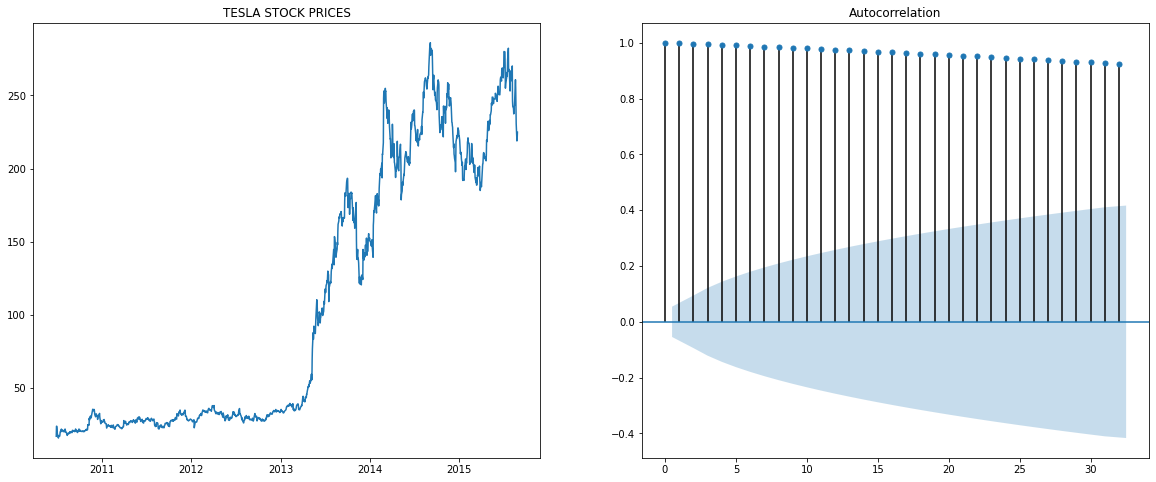

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # creating two spaces for plots

ax1.plot(train) # plotting the tesla stock prices
ax1.set_title("TESLA STOCK PRICES") # titling the first plot 
plot_acf(train, ax=ax2) # using the plot_acf to determine differences (the term d)
plt.show()

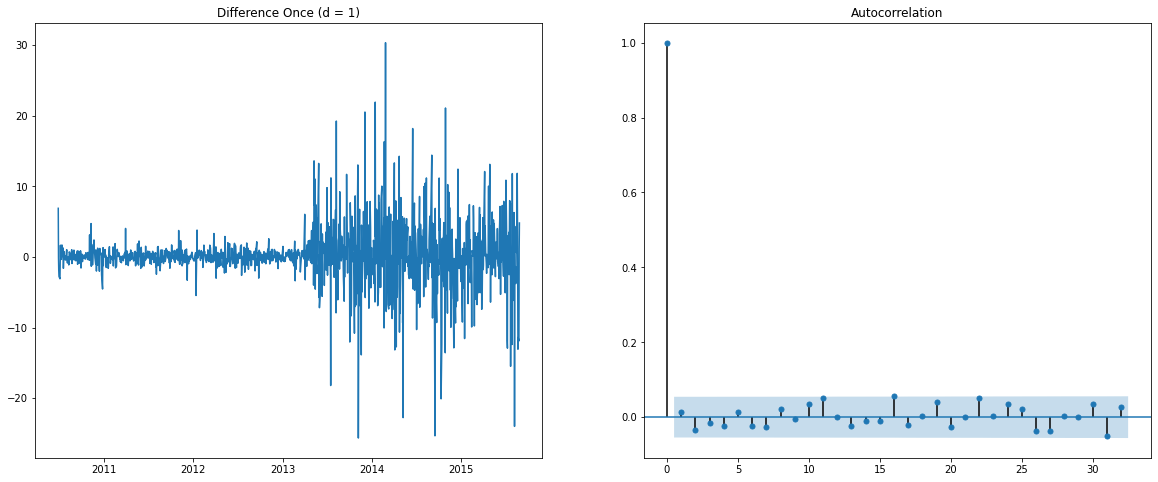

In [6]:
diff = train.Close.diff().dropna() # differencing by one term and dropping the NaN values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # creating two spaces for plots

ax1.plot(diff) # plotting the difference once
ax1.set_title("Difference Once (d = 1)") # titling the first plot 
plot_acf(diff, ax=ax2) # using the plot_acf to visualize autocorellation and stationarity and therefore determine the term d
plt.show()

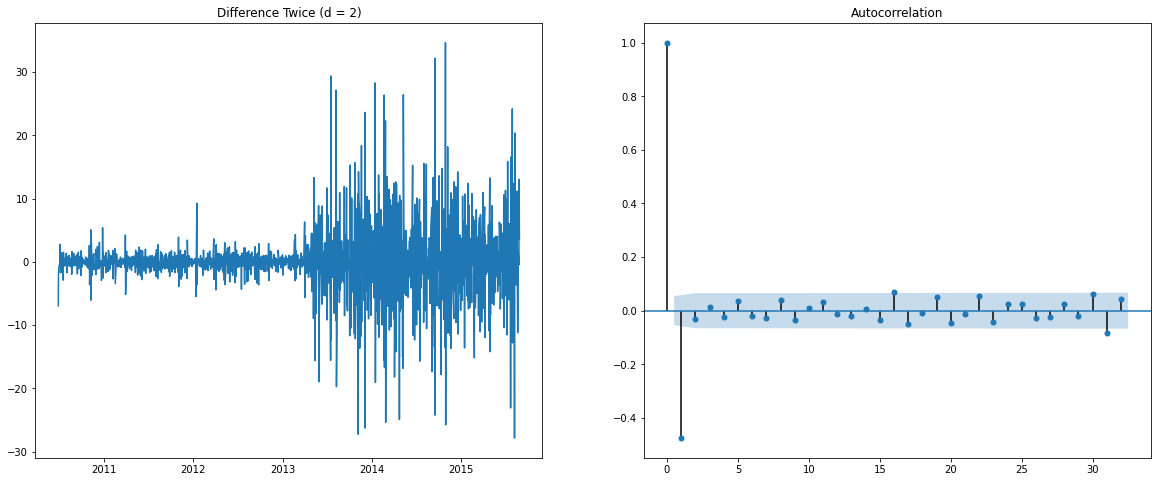

In [7]:
diff = train.Close.diff().diff().dropna() # differencing by one term and dropping the NaN values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # creating two spaces for plots

ax1.plot(diff) # plotting the difference once
ax1.set_title("Difference Twice (d = 2)") # titling the first plot 
plot_acf(diff, ax=ax2) # using the plot_acf to visualize autocorellation and stationarity and therefore determine the term d
plt.show()

We have reduced the autocorrelation and d = 1 seems to be a lot similar to d = 2 but we notice that when d = 2 the lag goes to the far negative which is an indicator that we have overdifferenced. Therefore the optimal choice for d is 1


#----------------- Term d is Determined ----------------

#----------------- Detrmining the p term ----------------

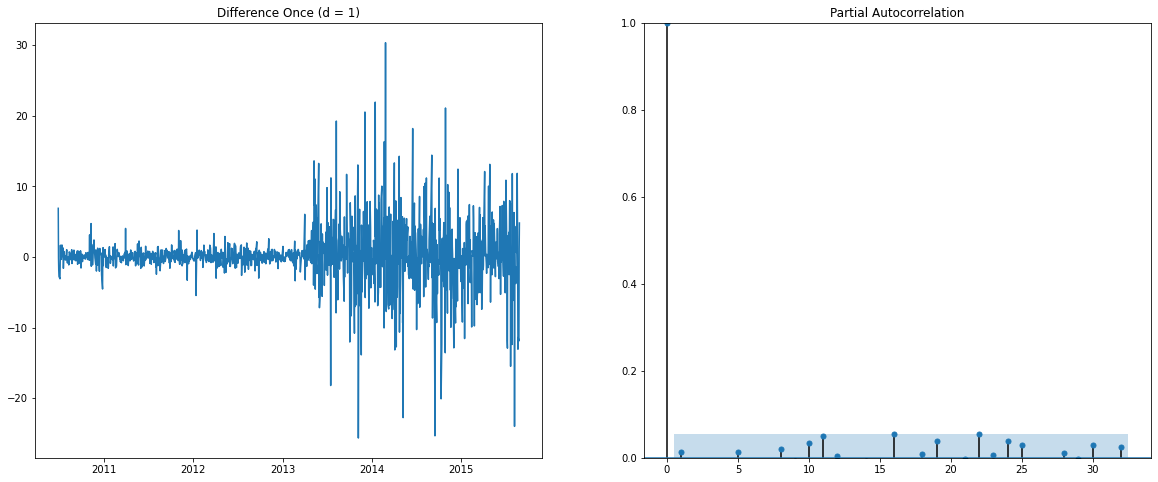

In [8]:
diff = train.Close.diff().dropna() # differencing by one term and dropping the NaN values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # creating two spaces for plots

ax1.plot(diff) # plotting the difference once
ax1.set_title("Difference Once (d = 1)") # titling the first plot 
ax2.set_ylim(0, 1) # setting limitations to the y axis from 0 to 1
plot_pacf(diff, ax=ax2) # using the plot_acf to visualize autocorellation and stationarity and therefore determine the term d
plt.show()

From the graph we can observe that the PACF lag 11 is as close to be significant as it is on of the highest, therefore we are chosing p = 11

#----------------- Term p is Determined ----------------

#----------------- Determining the q term ----------------

the term q is the order of the moving average (MA) term . It refers to the number of lagged forecast errors that should go into the ARIMA model.

We can look at the ACF plot for the number of MA terms

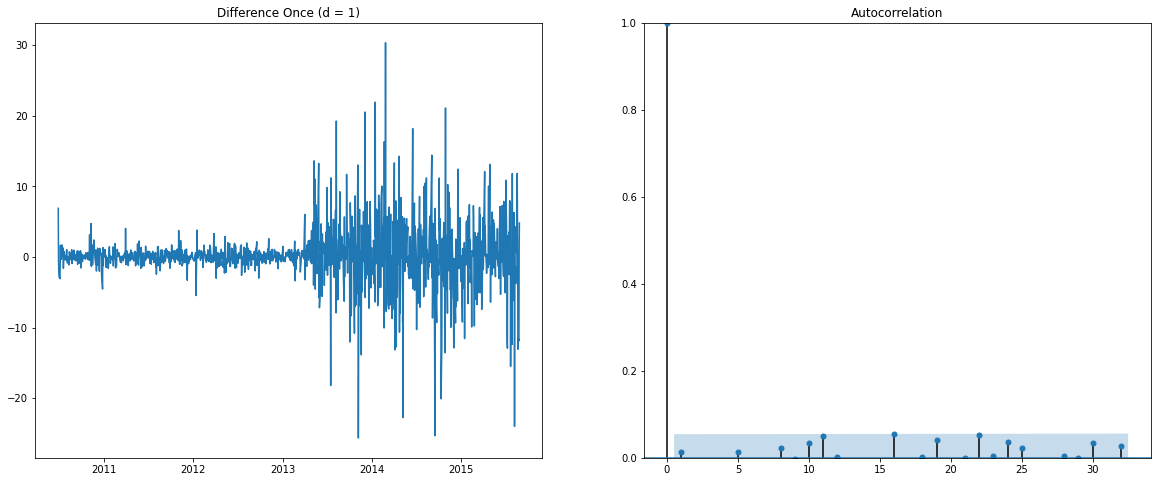

In [9]:
diff = train.Close.diff().dropna() # differencing by one term and dropping the NaN values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # creating two spaces for plots

ax1.plot(diff) # plotting the difference once
ax1.set_title("Difference Once (d = 1)") # titling the first plot 
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2) # using the plot_acf to visualize autocorellation and stationarity and therefore determine the term d
plt.show()

From the ACF plot we can see that the term 11 is suitable for the selection of q

And so we conclude q = 11

#----------------- Term q is Determined ----------------

Now we are ready to create our ARIMA model with d = 1,  p = 11, q = 11

In [10]:
# implementing the arima model with d = 1, p = 11 and q = 11
# creating our ARIMA model 
model = ARIMA(train, order=(11,1,11))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
print(result.summary()) # printing a summary of the results

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1299
Model:               ARIMA(11, 1, 11)   Log Likelihood               -3651.043
Method:                       css-mle   S.D. of innovations              3.995
Date:                Wed, 01 Jun 2022   AIC                           7350.086
Time:                        13:19:20   BIC                           7474.150
Sample:                             1   HQIC                          7396.637
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1622      0.118      1.375      0.169      -0.069       0.393
ar.L1.D.Close     -0.3719      0.544     -0.684      0.494      -1.438       0.694
ar.L2.D.Close      0.4723      0.384

We can see that our coefs are almost all good for evaluating our model since they are far from 0 and only 4 of them have p-value > 0.5 

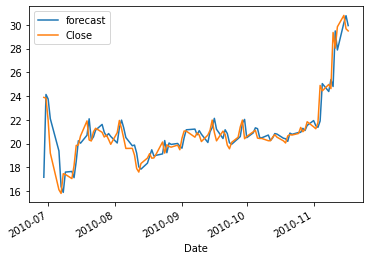

In [12]:
 # plotting the predictions vs the actual 
result.plot_predict( start=1, end=100, dynamic=False) # plotting the first 100 steps
plt.show()

In [13]:
# forecasting 100 steps 
step = 100
forecast, std_error, confidence = result.forecast(step)

we have our forecast, our standard error and the confidence level. We will use these to evaluate our model.

In [14]:
forecast = pd.Series(forecast, test[:step].index) # forecast of the next 100 days
lower = pd.Series(confidence[:, 0], test[:step].index) # this will be the lower limit of the confidence level for those 100 days
upper = pd.Series(confidence[:, 1], test[:step].index) # this will be the upper limit of the confidence level for those 100 days

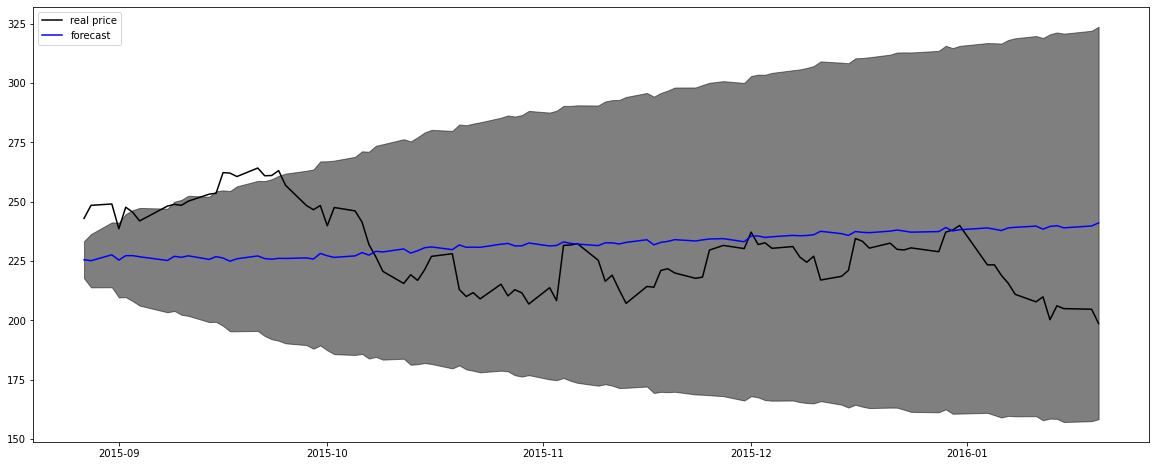

In [15]:
plt.figure(figsize=(20,8))
plt.plot(test[:step], label="real price", color = "k") # plotting the real price
plt.plot(forecast, label="forecast", color = "b") # plotting the forecast
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.5) # filling with a transparent black so as to see the confidence interval in grey 
plt.legend(loc="upper left")
plt.show()

The actual price is in the confidence interval which means that theoretically we could find an optimal arima model to predict stock prices.

But it is still not a profitable predictor